# Gaussian mixture (multi-modal) 2D
---
**Description**:

- Optimization (max)
- Multimodal (yes)
---

The equations are given by the Multivariate Normal Distribution, with **four** modes:

$f\left(\mathbf{x}\right) = \sum_{i=1}^{4}{\cal N}(\mu_i, \Sigma_i)$,

with mean vectors: $\mu_1 = [-0.0, -1.0]$, $\mu_2 = [-4.0, -6.0]$, $\mu_3 = [-5.0, +1.0]$, $\mu_4 = [5.0, -10.0]$,

and covariances: $\Sigma_1 = \begin{bmatrix} 1.0 & 0.1 \\ 0.1 & 1.0\end{bmatrix}$, 
$\Sigma_2 = \begin{bmatrix} 1.0 & 0.1 \\ 0.1 & 1.0\end{bmatrix}$, $\Sigma_3 = \begin{bmatrix} 1.2 & 0.3 \\ 0.3 & 1.2\end{bmatrix}$,
$\Sigma_4 = \begin{bmatrix} 1.2 & 0.3 \\ 0.3 & 1.2\end{bmatrix}$.

## Step 1: Import python libraries and set up the project directory

In [11]:
import os, sys
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
from scipy.stats import qmc, multivariate_normal

# Enable LaTex in plotting.
plt.rcParams["text.usetex"] = True

PROJECT_DIR = os.path.abspath("..")

if PROJECT_DIR not in sys.path:
    sys.path.append(PROJECT_DIR)

## Step 2: Import the custom PSO code

In [12]:
from star_pso.population.swarm import Swarm
from star_pso.population.particle import Particle
from star_pso.engines.standard_pso import StandardPSO
from star_pso.utils.auxiliary import cost_function

In [13]:
# Utility function that counts the particles per mode.
def count_particles_per_mode(x_pos: np.ndarray, modes: list,
                             radius: float = 1.0) -> dict:
    cppm = defaultdict(int)

    for px, py in x_pos:
        for vals in modes:
            cx, cy = vals
            if (px - cx)**2 + (py - cy)**2 <= radius**2:            
                cppm[tuple(vals)] += 1
                break
            # _end_if_
    # _end_for_
    return cppm
# _end_def_

## Step 3: Define the multi-modal function

In [14]:
# NOTE: Because of their covariance setup, the first two (mvn_1 and mvn_2)
# will have higher modes than the other two. So the maximum will be in one
# of these two modes.

# Each one with different mean and covariance matrix.
mvn_1 = multivariate_normal([-0.0, -1.0], [[1.0, 0.1], [0.1, 1.0]])

mvn_2 = multivariate_normal([-4.0, -6.0], [[1.0, 0.1], [0.1, 1.0]])

mvn_3 = multivariate_normal([-10.0, 5.0], [[1.2, 0.3], [0.3, 1.2]])

mvn_4 = multivariate_normal([5.0, -10.0], [[1.2, 0.3], [0.3, 1.2]])

# Define the negative log of the PDFs.
def negative_log_pdfx(x):
    return -np.log(mvn_1.pdf(x) + mvn_2.pdf(x) + mvn_3.pdf(x) + mvn_4.pdf(x))
# _end_def_

@cost_function(minimize=True)
def fun_gauss2D(x: np.ndarray, **kwargs) -> float:
    
    # Compute the final value.
    f_value = negative_log_pdfx(x)
    
    # Return the solution.
    return f_value.item()
# _end_def_

## Step 4: Set the PSO parameters

    - Number of particles 'N'
    - Initial population
    - PSO object

In [15]:
# Set a seed for reproducible initial population.
SEED = 1821

# Random number generator.
rng = np.random.default_rng(SEED)

# Define the size of the problem (number of particles, dimensions).
N, D = 45, 2

# Set the bounds.
l_bounds = [-15.0, -15.0]
u_bounds = [+15.0, +15.0]

# Define the sampling method.
sample_method = "RANDOM"

if sample_method == "RANDOM":
    # Draw random samples for the initial points.
    Xt0 = rng.uniform(-15.0, 15.0, size=(N, D))
else:
    # Draw samples using Latin Hyper Cube approach.
    sampler = qmc.LatinHypercube(D, optimization="random-cd", rng=rng)

    # Sample initial population.
    Xt0 = sampler.random(N)
    
    # Scale the population.
    Xt0 = qmc.scale(Xt0, l_bounds, u_bounds)
# _end_if_

# Initial population.
swarm_t0 = Swarm([Particle(x) for x in Xt0])

# Create a StandardPSO object that will perform the optimization.
test_PSO = StandardPSO(initial_swarm = swarm_t0, obj_func = fun_gauss2D,
                       x_min = l_bounds, x_max = u_bounds)

## Step 5: Run the optimization process

In [16]:
test_PSO.run(max_it = 500,
             options = {"w0": 0.70, "c1": 1.50, "c2": 1.50, "mode": "multimodal"},
             reset_swarm = False, verbose = True, adapt_params = False)

01/17/2026 19:05:13 INFO: Initial f_optimal = -1.8747
01/17/2026 19:05:13 INFO: Iteration:     1 -> f_optimal = -1.9106
01/17/2026 19:05:14 INFO: Iteration:    51 -> f_optimal = -1.8329
01/17/2026 19:05:14 INFO: Iteration:   101 -> f_optimal = -1.8329
01/17/2026 19:05:15 INFO: Iteration:   151 -> f_optimal = -1.8329
01/17/2026 19:05:15 INFO: Iteration:   201 -> f_optimal = -1.8329
01/17/2026 19:05:15 INFO: Iteration:   251 -> f_optimal = -1.8329
01/17/2026 19:05:16 INFO: Iteration:   301 -> f_optimal = -1.8329
01/17/2026 19:05:16 INFO: Iteration:   351 -> f_optimal = -1.8329
01/17/2026 19:05:16 INFO: Iteration:   401 -> f_optimal = -1.8329
01/17/2026 19:05:17 INFO: Iteration:   451 -> f_optimal = -1.8329


Final f_optimal = -1.8329
run: elapsed time = 3.967 seconds.


## Step 6: Extract the data for analysis and plotting

In [17]:
# Get the optimal solution from the PSO.
_, f_opt, x_opt = test_PSO.get_optimal_values()

# Print the results.
print(f"x={x_opt}, f(x) = {f_opt:.5f}")

x=[-3.00681729e-08 -1.00000003e+00], f(x) = -1.83285


### If requested extract other solutions

In [18]:
best_n = []

for p in test_PSO.swarm.best_n(N):
    best_n.append(p.position)
    
best_n = np.unique(np.array(best_n), axis=0)

### Prepare the plot

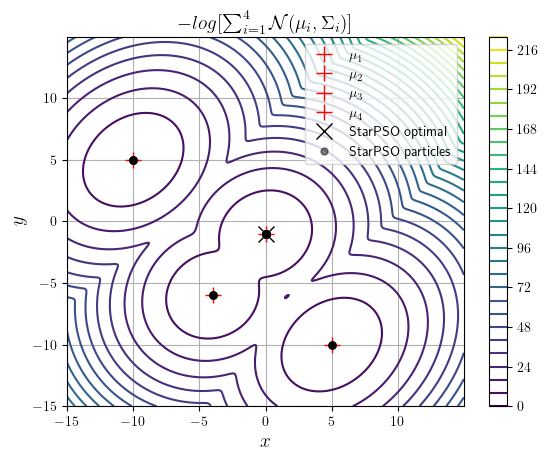

In [19]:
# Prepare the plot of the real density.
x, y = np.mgrid[-15:15:0.01, -15:15:0.01]

# Stack the position of the grid together.
pos = np.dstack((x, y))

# First plot the contour of the "true" function.
plt.contour(x, y, negative_log_pdfx(pos), levels=30)

# Add the three modes.
plt.plot(+0.0, -1.0, "r+", label="$\mu_1$", markersize=12)
plt.plot(-4.0, -6.0, "r+", label="$\mu_2$", markersize=12)
plt.plot(-10.0, 5.0, "r+", label="$\mu_3$", markersize=12)
plt.plot(5.0, -10.0, "r+", label="$\mu_4$", markersize=12)

# Plot the optimal PSO.
plt.plot(x_opt[0], x_opt[1], "kx", markersize=12, label="StarPSO optimal")

# Plot the best_n.
plt.plot(best_n[:, 0], best_n[:, 1], "ko", alpha=0.5, markersize=5, label="StarPSO particles")

# Add labels.
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.title("$-log[\sum_{i=1}^4{\cal N}(\mu_i, \Sigma_i)]$", fontsize=14)
plt.legend()

# Final setup.
plt.colorbar()
plt.grid()

# Save to file.
plt.savefig("Multimodal_2D.pdf", format="pdf", dpi=300)

In [20]:
counts = count_particles_per_mode(best_n, [[-0.0, -1.0],
                                           [-4.0, -6.0],
                                           [-10.0, 5.0],
                                           [5.0, -10.0]])

for i, vals in enumerate(counts.items(), start=1):
    optimum, n_particles = vals
    print(f"{i:>3}, optimum: ({optimum[0]:>+8.4f}, {optimum[1]:>+8.4f}), n-particles: {n_particles:>3}")

  1, optimum: (-10.0000,  +5.0000), n-particles:  10
  2, optimum: ( -4.0000,  -6.0000), n-particles:   7
  3, optimum: ( -0.0000,  -1.0000), n-particles:  22
  4, optimum: ( +5.0000, -10.0000), n-particles:   6


### End of file